In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

# Import datasets

In [2]:
csv_path = os.path.join("..", "..", "data","LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3_MICE5.csv")
tsr_all3_df = pd.read_csv(csv_path)
tsr_all3_df.shape

(39881, 234)

# Convert the multiple feature and outcome into binary ones

In [3]:
mRS3 = tsr_all3_df.mrs_tx_3
mRS3[(mRS3 == 0) | (mRS3 == 1) | (mRS3 == 2)] = 1 #GOOD
mRS3[(mRS3 == 3) | (mRS3 == 4) | (mRS3 == 5) | (mRS3 == 6) | (mRS3 == 9)] = 0 #BAD

# Group all features and the outcome

In [4]:
nominal_features = ["edu_id", "pro_id", "opc_id", "toast_id", "offdt_id", "gender_tx", "hd_id", "pcva_id",
                    "pcvaci_id", "pcvach_id", "po_id", "ur_id", "sm_id", "ptia_id", "hc_id", "hcht_id",
                    "hchc_id", "ht_id", "dm_id", "pad_id", "al_id", "ca_id", "fahiid_parents_1",
                    "fahiid_parents_2", "fahiid_parents_3", "fahiid_parents_4", "fahiid_brsi_1",
                    "fahiid_brsi_2", "fahiid_brsi_3", "fahiid_brsi_4"]
ordinal_features = ["gcse_nm", "gcsv_nm", "gcsm_nm", "discharged_mrs", "feeding", "transfers",
                    "bathing", "toilet_use", "grooming", "mobility", "stairs", "dressing", "bowel_control",
                    "bladder_control", "nihs_1a_in", "nihs_1b_in", "nihs_1c_in", "nihs_2_in", "nihs_3_in", "nihs_4_in",
                    "nihs_5al_in", "nihs_5br_in", "nihs_6al_in", "nihs_6br_in", "nihs_7_in", "nihs_8_in", "nihs_9_in",
                    "nihs_10_in", "nihs_11_in", "nihs_1a_out", "nihs_1b_out", "nihs_1c_out", "nihs_2_out", "nihs_3_out",
                    "nihs_4_out", "nihs_5al_out", "nihs_5br_out", "nihs_6al_out", "nihs_6br_out", "nihs_7_out",
                    "nihs_8_out", "nihs_9_out", "nihs_10_out", "nihs_11_out"]
boolean = ["toastle_fl", "toastli_fl", "toastsce_fl", "toastsmo_fl", "toastsra_fl", "toastsdi_fl",
           "toastsmi_fl", "toastsantip_fl", "toastsau_fl", "toastshy_fl", "toastspr_fl", "toastsantit_fl",
           "toastsho_fl", "toastshys_fl", "toastsca_fl", "thda_fl", "thdh_fl", "thdi_fl", "thdam_fl", "thdv_fl",
           "thde_fl", "thdm_fl", "thdr_fl", "thdp_fl", "trman_fl", "trmas_fl", "trmti_fl", "trmhe_fl",
           "trmwa_fl", "trmia_fl", "trmfo_fl", "trmta_fl", "trmsd_fl", "trmre_fl", "trmen_fl", "trmag_fl",
           "trmcl_fl", "trmpl_fl", "trmlm_fl", "trmiv_fl", "trmve_fl", "trmng_fl", "trmdy_fl", "trmicu_fl",
           "trmsm_fl", "trmed_fl", "trmop_fl", "om_fl", "omas_fl", "omag_fl", "omti_fl", "omcl_fl", "omwa_fl",
           "ompl_fl", "omanh_fl", "omand_fl", "omli_fl", "am_fl", "amas_fl", "amag_fl", "amti_fl", "amcl_fl",
           "amwa_fl", "ampl_fl", "amanh_fl", "amand_fl", "amli_fl", "compn_fl", "comut_fl", "comug_fl",
           "compr_fl", "compu_fl", "comac_fl", "comse_fl", "comde_fl", "detst_fl", "dethe_fl", "detho_fl",
           "detha_fl", "detva_fl", "detre_fl", "detme_fl", "ct_fl", "mri_fl", "ecgl_fl", "ecga_fl", "ecgq_fl",
           "cortical_aca_ctr", "cortical_mca_ctr", "subcortical_aca_ctr", "subcortical_mca_ctr", "pca_cortex_ctr",
           "thalamus_ctr", "brainstem_ctr", "cerebellum_ctr", "watershed_ctr", "hemorrhagic_infarct_ctr",
           "old_stroke_ctci", "cortical_aca_ctl", "cortical_mca_ctl", "subcortical_aca_ctl", "subcortical_mca_ctl",
           "pca_cortex_ctl", "thalamus_ctl", "brainstem_ctl", "cerebellum_ctl", "watershed_ctl",
           "hemorrhagic_infarct_ctl", "old_stroke_ctch", "cortical_aca_mrir", "cortical_mca_mrir",
           "subcortical_aca_mrir", "subcortical_mca_mrir", "pca_cortex_mrir", "thalamus_mrir", "brainstem_mrir",
           "cerebellum_mrir", "watershed_mrir", "hemorrhagic_infarct_mrir", "old_stroke_mrici", "cortical_aca_mril",
           "cortical_mca_mril", "subcortical_aca_mril", "subcortical_mca_mril", "pca_cortex_mril",
           "thalamus_mril", "brainstem_mril", "cerebellum_mril", "watershed_mril", "hemorrhagic_infarct_mril",
           "old_stroke_mrich"]
continuous = ["height_nm", "weight_nm", "sbp_nm", "dbp_nm", "bt_nm", "hr_nm", "rr_nm", "hb_nm",
              "hct_nm", "platelet_nm", "wbc_nm", "ptt1_nm", "ptt2_nm", "ptinr_nm", "er_nm", "bun_nm",
              "cre_nm", "ua_nm", "tcho_nm", "tg_nm", "hdl_nm",
              "ldl_nm", "gpt_nm", "age", "hospitalised_time"]
labels = ["mrs_tx_3", "mrs_tx_1"]

# Machine Learning

## Preprocess input data (GOOD when Discharge)

In [5]:
## discharged mRS = GOOD (tsr_all3_df.discharged_mrs == 1)
mrs_dis1 = tsr_all3_df[(tsr_all3_df.discharged_mrs == 1) | (tsr_all3_df.discharged_mrs == 0) | (tsr_all3_df.discharged_mrs == 2)]

In [6]:
## input dataset
tsr_3G_input = mrs_dis1.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1)
print(tsr_3G_input.shape)
tsr_3G_input = tsr_3G_input.astype("float64")
tsr_3G_input = np.array(tsr_3G_input.values)

(18940, 231)


In [7]:
## output dataset
tsr_3G_output = mrs_dis1.mrs_tx_3
print(tsr_3G_output.shape)
tsr_3G_output = tsr_3G_output.astype("float64")
tsr_3G_output = np.array(tsr_3G_output.values)

(18940,)


In [8]:
## train_test_split
G_X_train, G_X_test, G_y_train, G_y_test = train_test_split(tsr_3G_input, tsr_3G_output, test_size=0.3, random_state=19)
print("The shape of GOOD's X_train:", G_X_train.shape)
print("The shape of GOOD's y_train:", G_y_train.shape)
print("The shape of GOOD's X_test:", G_X_test.shape)
print("The shape of GOOD's y_test:", G_y_test.shape)

The shape of GOOD's X_train: (13258, 231)
The shape of GOOD's y_train: (13258,)
The shape of GOOD's X_test: (5682, 231)
The shape of GOOD's y_test: (5682,)


In [9]:
## scale G_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
G_X_train = pd.DataFrame(G_X_train)
G_X_train.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

scaler = MinMaxScaler()
G_X_train[continuous] = scaler.fit_transform(G_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=6)
G_X_train[ordinal_features] = encoder.fit_transform(G_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
nominal_train = ohe.fit_transform(G_X_train[nominal_features])
G_X_train = pd.concat([G_X_train, pd.DataFrame(nominal_train)], axis=1)
G_X_train = G_X_train.drop(nominal_features, axis=1)

G_x_train_columns = list(G_X_train.columns)
G_x_train_columns = G_x_train_columns[0:201]
get_feature_name = list(ohe.get_feature_names(nominal_features))
G_x_train_columns = G_x_train_columns+get_feature_name
G_X_train.columns = G_x_train_columns

#G_X_train = np.array(G_X_train.values)

In [10]:
## scale G_X_test
G_X_test = pd.DataFrame(G_X_test)
G_X_test.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

G_X_test[continuous] = scaler.transform(G_X_test[continuous])

G_X_test[ordinal_features] = encoder.transform(G_X_test[ordinal_features])

nominal_test = ohe.transform(G_X_test[nominal_features])
G_X_test = pd.concat([G_X_test, pd.DataFrame(nominal_test)], axis=1)
G_X_test = G_X_test.drop(nominal_features, axis=1)
G_X_test.columns = G_x_train_columns

#G_X_test = np.array(G_X_test.values)

## Algorithms

## Extra trees

In [11]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 24}, {0: 24, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter=100,
                              random_state=19)

In [12]:
### BASED ET
etG = et.fit(G_X_train, G_y_train)

G_y_train_pred = etG.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc = auc(fpr, tpr)
#print('AUC of training set:', G_train_auroc)

G_y_test_pred = etG.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

### TUNED ET
etG_rsCV = etG_rscv.fit(G_X_train, G_y_train)
print('--> Tuned Parameters Best Score: ', etG_rsCV.best_score_)
print('--> Best Parameters: \n', etG_rsCV.best_params_)

G_y_train_pred = etG_rsCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_tuned = auc(fpr, tpr)
#print('AUC of training set:', G_train_auroc_tuned)

G_y_test_pred = etG_rsCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

### CALIBRATED ET
etG_cccv = CalibratedClassifierCV(base_estimator=etG_rsCV.best_estimator_, cv=5)
etG_ccCV = etG_cccv.fit(G_X_train, G_y_train)

G_y_train_pred = etG_ccCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_cc = auc(fpr, tpr)
#print('AUC of training set:', G_train_auroc_cc)

G_y_test_pred = etG_ccCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

AUC of testing set: 0.8004578781605608
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--> Tuned Parameters Best Score:  0.837636929956145
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.9, 'extratreesclassifier__max_depth': 25, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': 'balanced', 'extratreesclassifier__bootstrap': True}
AUC of testing set: 0.8345204717072615
AUC of testing set: 0.8373217078939712


## Thresholds

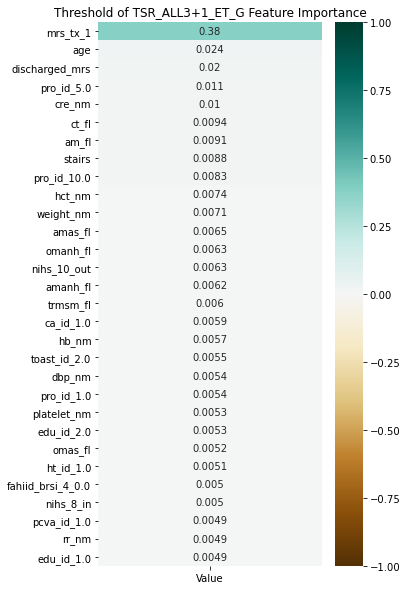

In [13]:
etG_sigma = etG_rsCV.best_estimator_._final_estimator.feature_importances_
etG_sigma_df = pd.DataFrame(etG_sigma)
etG_sigma_df.index = G_x_train_columns
etG_sigma_df.columns = (["Value"])
etG_sigma_plot = etG_sigma_df.sort_values(["Value"], ascending=False).head(30)

plt.figure(figsize=(5, 10))
sns.heatmap(etG_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL3+1_ET_G Feature Importance')
#plt.savefig('INFO/TSR_ALL3/etG31_sigma_df.png')
plt.show()

### Selected Columns

In [14]:
etG_sigma_df = etG_sigma_df.reset_index(drop=False)
etG_sigma_df.columns = (["Feature","Value"])
etG_sigma_df = etG_sigma_df.sort_values(["Value"], ascending=False)

G_X_train = pd.DataFrame(G_X_train)
G_X_test = pd.DataFrame(G_X_test)

In [15]:
G_train_auroc_list = []
G_test_auroc_list = []
G_train_auroc_tuned_list = []
G_test_auroc_tuned_list = []
G_train_auroc_cc_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    etG_sigma_index = etG_sigma_df[0:i].index
    
    G_X_train_selected = G_X_train.iloc[:, etG_sigma_index]
    #G_X_train_selected = np.array(G_X_train_selected.values)
    
    G_X_test_selected = G_X_test.iloc[:, etG_sigma_index]
    #G_X_test_selected = np.array(G_X_test_selected.values)
    
    # base et_selected
    et_selected = ExtraTreesClassifier(random_state=19)
    etG_selected = et_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = etG_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected = auc(fpr, tpr)
    G_train_auroc_list.append(G_train_auroc_selected)
    #print('AUC of training set:', G_train_auroc_selected)
    
    G_y_test_pred = etG_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    print('AUC of testing set:', G_test_auroc_selected)
    
    # tune et_selected   
    etG_rscv_selected = etG_rsCV.best_estimator_
    etG_rsCV_selected = etG_rscv_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = etG_rsCV_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_tuned = auc(fpr, tpr)
    G_train_auroc_tuned_list.append(G_train_auroc_selected_tuned)
    #print('AUC of training set:', G_train_auroc_selected_tuned)

    G_y_test_pred = etG_rsCV_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)
    print('AUC of testing set:', G_test_auroc_selected_tuned)

    # calibrate et_selected 
    etG_cccv_selected = CalibratedClassifierCV(base_estimator=etG_rsCV_selected, cv=5)
    etG_ccCV_selected = etG_cccv_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = etG_ccCV_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_cc = auc(fpr, tpr)
    G_train_auroc_cc_list.append(G_train_auroc_selected_cc)
    #print('AUC of training set:', G_train_auroc_selected_cc)

    G_y_test_pred = etG_ccCV_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    print('AUC of testing set:', G_test_auroc_selected_cc)
    
G_train_auroc_list.append(G_train_auroc)
G_test_auroc_list.append(G_test_auroc)
G_train_auroc_tuned_list.append(G_train_auroc_tuned)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_train_auroc_cc_list.append(G_train_auroc_cc)
G_test_auroc_cc_list.append(G_test_auroc_cc)

AUC of testing set: 0.784607114397865
AUC of testing set: 0.8375236633625798
AUC of testing set: 0.8370105531218773
AUC of testing set: 0.806976950092967
AUC of testing set: 0.8317242949477404
AUC of testing set: 0.8399635721242427
AUC of testing set: 0.8136170266589651
AUC of testing set: 0.8379672064794397
AUC of testing set: 0.8436409324524308


 99%|===================| 11282/11364 [00:19<00:00]        

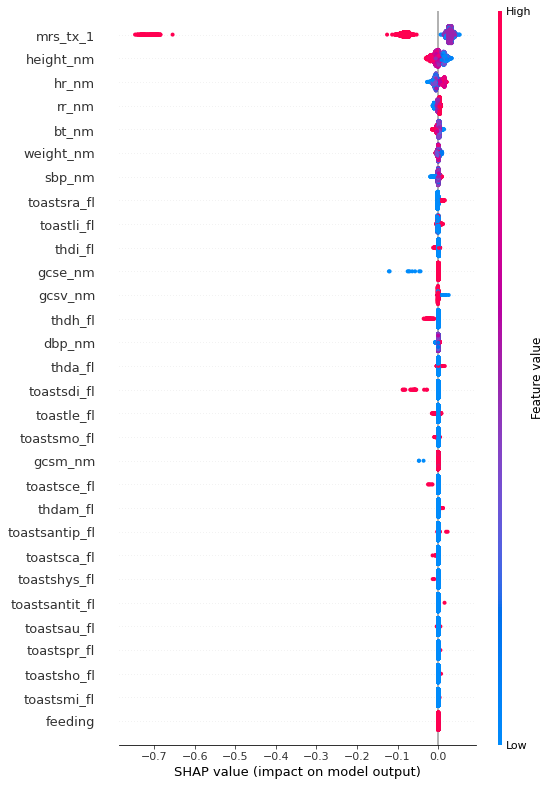

In [16]:
etG31_shap_values = shap.TreeExplainer(etG_ccCV_selected.base_estimator._final_estimator, G_X_test).shap_values(G_X_test)
shap.summary_plot(etG31_shap_values[1], G_X_test, max_display=30)

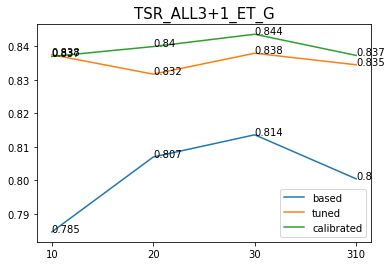

In [17]:
x = "10","20","30","310"
#plt.plot(x, G_train_auroc_list, label = "training")
plt.plot(x, G_test_auroc_list, label = "based")
#plt.plot(x, G_train_auroc_tuned_list, label = "training")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, G_train_auroc_cc_list, label = "training")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL3+1_ET_G', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL31_ET_G.png')
plt.show()

## XGBClassifier

In [18]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.04, 24)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcG_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=100,
                                random_state=19)

In [ ]:
### BASED XGBC
xgbcG = xgbc.fit(G_X_train, G_y_train)

G_y_train_pred = xgbcG.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train , G_y_train_pred[:, 1])
G_train_auroc = auc(fpr, tpr)
#print('AUC of training set:', G_train_auroc)

G_y_test_pred = xgbcG.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

### TUNED XGBC
xgbcG_rsCV = xgbcG_rscv.fit(G_X_train, G_y_train)
print("--> Tuned Parameters Best Score: ", xgbcG_rsCV.best_score_)
print("--> Best Parameters: \n", xgbcG_rsCV.best_params_)

G_y_train_pred = xgbcG_rsCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_tuned = auc(fpr, tpr)
#print('AUC of training set:', G_train_auroc_tuned)

G_y_test_pred = xgbcG_rsCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

### CALIBRATED XGBC
xgbcG_cccv = CalibratedClassifierCV(base_estimator=xgbcG_rsCV.best_estimator_, cv=5)
xgbcG_ccCV = xgbcG_cccv.fit(G_X_train, G_y_train)

G_y_train_pred = xgbcG_ccCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_cc = auc(fpr, tpr)
#print('AUC of training set:', G_train_auroc_cc)

G_y_test_pred = xgbcG_ccCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

AUC of testing set: 0.8054266572786185
Fitting 5 folds for each of 100 candidates, totalling 500 fits


## Thresholds

In [ ]:
xgbcG_sigma = xgbcG_rsCV.best_estimator_._final_estimator.feature_importances_
xgbcG_sigma_df = pd.DataFrame(xgbcG_sigma)
xgbcG_sigma_df.index = G_x_train_columns
xgbcG_sigma_df.columns = (["Value"])
xgbcG_sigma_plot = xgbcG_sigma_df.sort_values(["Value"], ascending=False).head(30)

plt.figure(figsize=(5, 10))
sns.heatmap(xgbcG_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL3+1_XGBC_G Feature Importance')
#plt.savefig('INFO/TSR_ALL3/xgbcG31_sigma_df.png')
plt.show()

### Selected Columns

In [ ]:
xgbcG_sigma_df = xgbcG_sigma_df.reset_index(drop=False)
xgbcG_sigma_df.columns = (["Feature","Value"])
xgbcG_sigma_df = xgbcG_sigma_df.sort_values(["Value"], ascending=False)

G_X_train = pd.DataFrame(G_X_train)
G_X_test = pd.DataFrame(G_X_test)

In [ ]:
G_train_auroc_list = []
G_test_auroc_list = []
G_train_auroc_tuned_list = []
G_test_auroc_tuned_list = []
G_train_auroc_cc_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcG_sigma_index = xgbcG_sigma_df[0:i].index
    
    G_X_train_selected = G_X_train.iloc[:, xgbcG_sigma_index]
    #G_X_train_selected = np.array(G_X_train_selected.values)
    
    G_X_test_selected = G_X_test.iloc[:, xgbcG_sigma_index]
    #G_X_test_selected = np.array(G_X_test_selected.values)
    
    # base xgbc_selected
    xgbc_selected = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)
    xgbcG_selected = xgbc_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = xgbcG_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected = auc(fpr, tpr)
    G_train_auroc_list.append(G_train_auroc_selected)
    #print('AUC of training set:', G_train_auroc_selected)
    
    G_y_test_pred = xgbcG_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    print('AUC of testing set:', G_test_auroc_selected)

    # tune xgbc_selected
    xgbcG_rscv_selected = xgbcG_rsCV.best_estimator_
    xgbcG_rsCV_selected = xgbcG_rscv_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = xgbcG_rsCV_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_tuned = auc(fpr, tpr)
    G_train_auroc_tuned_list.append(G_train_auroc_selected_tuned)
    #print('AUC of training set:', G_train_auroc_selected_tuned)

    G_y_test_pred = xgbcG_rsCV_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)
    print('AUC of testing set:', G_test_auroc_selected_tuned)

    # calibrate xgbc_selected
    xgbcG_cccv_selected = CalibratedClassifierCV(base_estimator=xgbcG_rsCV_selected, cv=5)
    xgbcG_ccCV_selected = xgbcG_cccv_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = xgbcG_ccCV_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_cc = auc(fpr, tpr)
    G_train_auroc_cc_list.append(G_train_auroc_selected_cc)
    #print('AUC of training set:', G_train_auroc_selected_cc)

    G_y_test_pred = xgbcG_ccCV_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    print('AUC of testing set:', G_test_auroc_selected_cc)
    
G_train_auroc_list.append(G_train_auroc)
G_test_auroc_list.append(G_test_auroc)
G_train_auroc_tuned_list.append(G_train_auroc_tuned)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_train_auroc_cc_list.append(G_train_auroc_cc)
G_test_auroc_cc_list.append(G_test_auroc_cc)

In [ ]:
xgbcG31_shap_values = shap.TreeExplainer(xgbcG_ccCV_selected.base_estimator._final_estimator, G_X_test).shap_values(G_X_test)
shap.summary_plot(xgbcG31_shap_values, G_X_test, max_display=30)

In [ ]:
x = "10","20","30","310"
#plt.plot(x, G_train_auroc_list, label = "training")
plt.plot(x, G_test_auroc_list, label = "based")
#plt.plot(x, G_train_auroc_tuned_list, label = "training")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, G_train_auroc_cc_list, label = "training")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL3+1_XGBC_G', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL31_XGBC_G.png')
plt.show()

# Machine Learning

## Preprocess input data (BAD when Discharge)

In [ ]:
# discharged mRS = BAD (tsr_all3_df.discharged_mrs == 0)
mrs_dis0 = tsr_all3_df[(tsr_all3_df.discharged_mrs != 1) & (tsr_all3_df.discharged_mrs != 0) & (tsr_all3_df.discharged_mrs != 2)]

In [ ]:
## input dataset
tsr_3B_input = mrs_dis0.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1)
print(tsr_3B_input.shape)
tsr_3B_input = tsr_3B_input.astype("float64")
tsr_3B_input = np.array(tsr_3B_input.values)

In [ ]:
## output dataset
tsr_3B_output = mrs_dis0.mrs_tx_3
print(tsr_3B_output.shape)
tsr_3B_output = tsr_3B_output.astype("float64")
tsr_3B_output = np.array(tsr_3B_output.values)

In [ ]:
## train_test_split
B_X_train, B_X_test, B_y_train, B_y_test = train_test_split(tsr_3B_input, tsr_3B_output, test_size=0.3, random_state=19)
print("The shape of X_train:", B_X_train.shape)
print("The shape of y_train:", B_y_train.shape)
print("The shape of X_test:", B_X_test.shape)
print("The shape of y_test:", B_y_test.shape)

In [ ]:
## scale B_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

B_X_train = pd.DataFrame(B_X_train)
B_X_train.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

scaler = MinMaxScaler()
B_X_train[continuous] = scaler.fit_transform(B_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=9)
B_X_train[ordinal_features] = encoder.fit_transform(B_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False)
nominal_train = ohe.fit_transform(B_X_train[nominal_features])
B_X_train = pd.concat([B_X_train, pd.DataFrame(nominal_train)], axis=1)
B_X_train = B_X_train.drop(nominal_features, axis=1)

B_x_train_columns = list(B_X_train.columns)
B_x_train_columns = B_x_train_columns[0:201]
get_feature_name = list(ohe.get_feature_names(nominal_features))
B_x_train_columns = B_x_train_columns+get_feature_name
B_X_train.columns = B_x_train_columns

#B_X_train = np.array(B_X_train.values)

In [ ]:
## scale B_X_test
B_X_test = pd.DataFrame(B_X_test)
B_X_test.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

B_X_test[continuous] = scaler.transform(B_X_test[continuous])

B_X_test[ordinal_features] = encoder.transform(B_X_test[ordinal_features])

nominal_test = ohe.transform(B_X_test[nominal_features])
B_X_test = pd.concat([B_X_test, pd.DataFrame(nominal_test)], axis=1)
B_X_test = B_X_test.drop(nominal_features, axis=1)
B_X_test.columns = B_x_train_columns

#B_X_test = np.array(B_X_test.values)

## Algorithms

## Extra trees

In [ ]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 3}, {0: 3, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter=100,
                              random_state=19)

In [ ]:
### BASED ET
etB = et.fit(B_X_train, B_y_train)

B_y_train_pred = etB.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc = auc(fpr, tpr)
#print('AUC of training set:', B_train_auroc)

B_y_test_pred = etB.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

### TUNED ET
etB_rsCV = etB_rscv.fit(B_X_train, B_y_train)
print('--> Tuned Parameters Best Score: ', etB_rsCV.best_score_)
print('--> Best Parameters: \n', etB_rsCV.best_params_)

B_y_train_pred = etB_rsCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_tuned = auc(fpr, tpr)
#print('AUC of training set:', B_train_auroc_tuned)

B_y_test_pred = etB_rsCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

### CALIBRATED ET
etB_cccv = CalibratedClassifierCV(base_estimator=etB_rsCV.best_estimator_, cv=5)
etB_ccCV = etB_cccv.fit(B_X_train, B_y_train)

B_y_train_pred = etB_ccCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_cc = auc(fpr, tpr)
#print('AUC of training set:', B_train_auroc_cc)

B_y_test_pred = etB_ccCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

## Thresholds

In [ ]:
etB_sigma = etB_rsCV.best_estimator_._final_estimator.feature_importances_
etB_sigma_df = pd.DataFrame(etB_sigma)
etB_sigma_df.index = B_x_train_columns
etB_sigma_df.columns = (["Value"])
etB_sigma_plot = etB_sigma_df.sort_values(["Value"], ascending=False).head(30)

plt.figure(figsize=(5, 10))
sns.heatmap(etB_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL3+1_ET_B Feature Importance')
#plt.savefig('INFO/TSR_ALL3/etB31_sigma_df.png')
plt.show()

### Selected Columns

In [ ]:
etB_sigma_df = etB_sigma_df.reset_index(drop=False)
etB_sigma_df.columns = (["Feature","Value"])
etB_sigma_df = etB_sigma_df.sort_values(["Value"], ascending=False)

B_X_train = pd.DataFrame(B_X_train)
B_X_test = pd.DataFrame(B_X_test)

In [ ]:
B_train_auroc_list = []
B_test_auroc_list = []
B_train_auroc_tuned_list = []
B_test_auroc_tuned_list = []
B_train_auroc_cc_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    etB_sigma_index = etB_sigma_df[0:i].index
    
    B_X_train_selected = B_X_train.iloc[:, etB_sigma_index]
    #B_X_train_selected = np.array(B_X_train_selected.values)
    
    B_X_test_selected = B_X_test.iloc[:, etB_sigma_index]
    #B_X_test_selected = np.array(B_X_test_selected.values)
    
    # base et_selected
    et_selected = ExtraTreesClassifier(random_state=19)
    etB_selected = et_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = etB_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected = auc(fpr, tpr)
    B_train_auroc_list.append(B_train_auroc_selected)
    #print('AUC of training set:', B_train_auroc_selected)
    
    B_y_test_pred = etB_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    print('AUC of testing set:', B_test_auroc_selected)
    
    # tune et_selected   
    etB_rscv_selected = etB_rsCV.best_estimator_
    etB_rsCV_selected = etB_rscv_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = etB_rsCV_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_tuned = auc(fpr, tpr)
    B_train_auroc_tuned_list.append(B_train_auroc_selected_tuned)
    #print('AUC of training set:', B_train_auroc_selected_tuned)

    B_y_test_pred = etB_rsCV_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)
    print('AUC of testing set:', B_test_auroc_selected_tuned)

    # calibrate et_selected 
    etB_cccv_selected = CalibratedClassifierCV(base_estimator=etB_rsCV_selected, cv=5)
    etB_ccCV_selected = etB_cccv_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = etB_ccCV_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_cc = auc(fpr, tpr)
    B_train_auroc_cc_list.append(B_train_auroc_selected_cc)
    #print('AUC of training set:', B_train_auroc_selected_cc)

    B_y_test_pred = etB_ccCV_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    print('AUC of testing set:', B_test_auroc_selected_cc)
    
B_train_auroc_list.append(B_train_auroc)
B_test_auroc_list.append(B_test_auroc)
B_train_auroc_tuned_list.append(B_train_auroc_tuned)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_train_auroc_cc_list.append(B_train_auroc_cc)
B_test_auroc_cc_list.append(B_test_auroc_cc)

In [ ]:
etB31_shap_values = shap.TreeExplainer(etB_ccCV_selected.base_estimator._final_estimator, B_X_test).shap_values(B_X_test)
shap.summary_plot(etB31_shap_values[1], B_X_test, max_display=30)

In [ ]:
x = "10","20","30","311"
#plt.plot(x, B_train_auroc_list, label = "training")
plt.plot(x, B_test_auroc_list, label = "based")
#plt.plot(x, B_train_auroc_tuned_list, label = "training")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, B_train_auroc_cc_list, label = "training")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL3+1_ET_B', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL31_ET_B.png')
plt.show()

## XGBClassifier

In [ ]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.33, 3)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcB_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=100,
                                random_state=19)

In [ ]:
### BASED XGBC
xgbcB = xgbc.fit(B_X_train, B_y_train)

B_y_train_pred = xgbcB.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train , B_y_train_pred[:, 1])
B_train_auroc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc)

B_y_test_pred = xgbcB.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

### TUNED XGBC
xgbcB_rsCV = xgbcB_rscv.fit(B_X_train, B_y_train)
print("--> Tuned Parameters Best Score: ", xgbcB_rsCV.best_score_)
print("--> Best Parameters: \n", xgbcB_rsCV.best_params_)

B_y_train_pred = xgbcB_rsCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_tuned)

B_y_test_pred = xgbcB_rsCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

### CALIBRATED XGBC
xgbcB_cccv = CalibratedClassifierCV(base_estimator=xgbcB_rsCV.best_estimator_, cv=5)
xgbcB_ccCV = xgbcB_cccv.fit(B_X_train, B_y_train)

B_y_train_pred = xgbcB_ccCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_cc)

B_y_test_pred = xgbcB_ccCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

## Thresholds

In [ ]:
xgbcB_sigma = xgbcB_rsCV.best_estimator_._final_estimator.feature_importances_
xgbcB_sigma_df = pd.DataFrame(xgbcB_sigma)
xgbcB_sigma_df.index = B_x_train_columns
xgbcB_sigma_df.columns = (["Value"])
xgbcB_sigma_plot = xgbcB_sigma_df.sort_values(["Value"], ascending=False).head(30)

plt.figure(figsize=(5, 10))
sns.heatmap(xgbcB_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL3+1_XGBC_B Feature Importance')
#plt.savefig('INFO/TSR_ALL3/xgbcB31_sigma_df.png')
plt.show()

### Selected Columns

In [ ]:
xgbcB_sigma_df = xgbcB_sigma_df.reset_index(drop=False)
xgbcB_sigma_df.columns = (["Feature","Value"])
xgbcB_sigma_df = xgbcB_sigma_df.sort_values(["Value"], ascending=False)

B_X_train = pd.DataFrame(B_X_train)
B_X_test = pd.DataFrame(B_X_test)

In [ ]:
B_train_auroc_list = []
B_test_auroc_list = []
B_train_auroc_tuned_list = []
B_test_auroc_tuned_list = []
B_train_auroc_cc_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcB_sigma_index = xgbcB_sigma_df[0:i].index
    
    B_X_train_selected = B_X_train.iloc[:, xgbcB_sigma_index]
    #B_X_train_selected = np.array(B_X_train_selected.values)
    
    B_X_test_selected = B_X_test.iloc[:, xgbcB_sigma_index]
    #B_X_test_selected = np.array(B_X_test_selected.values)
    
    # base xgbc_selected
    xgbc_selected = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)
    xgbcB_selected = xgbc_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = xgbcB_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected = auc(fpr, tpr)
    B_train_auroc_list.append(B_train_auroc_selected)
    #print('AUC of training set:', B_train_auroc_selected)
    
    B_y_test_pred = xgbcB_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    print('AUC of testing set:', B_test_auroc_selected)

    # tune xgbc_selected
    xgbcB_rscv_selected = xgbcB_rsCV.best_estimator_
    xgbcB_rsCV_selected = xgbcB_rscv_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = xgbcB_rsCV_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_tuned = auc(fpr, tpr)
    B_train_auroc_tuned_list.append(B_train_auroc_selected_tuned)
    #print('AUC of training set:', B_train_auroc_selected_tuned)

    B_y_test_pred = xgbcB_rsCV_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)
    print('AUC of testing set:', B_test_auroc_selected_tuned)

    # calibrate xgbc_selected
    xgbcB_cccv_selected = CalibratedClassifierCV(base_estimator=xgbcB_rsCV_selected, cv=5)
    xgbcB_ccCV_selected = xgbcB_cccv_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = xgbcB_ccCV_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_cc = auc(fpr, tpr)
    B_train_auroc_cc_list.append(B_train_auroc_selected_cc)
    #print('AUC of training set:', B_train_auroc_selected_cc)

    B_y_test_pred = xgbcB_ccCV_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    print('AUC of testing set:', B_test_auroc_selected_cc)
    
B_train_auroc_list.append(B_train_auroc)
B_test_auroc_list.append(B_test_auroc)
B_train_auroc_tuned_list.append(B_train_auroc_tuned)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_train_auroc_cc_list.append(B_train_auroc_cc)
B_test_auroc_cc_list.append(B_test_auroc_cc)

In [ ]:
xgbcB31_shap_values = shap.TreeExplainer(xgbcB_ccCV_selected.base_estimator._final_estimator, B_X_test).shap_values(B_X_test)
shap.summary_plot(xgbcB31_shap_values, B_X_test, max_display=30)

In [ ]:
x = "10","20","30","311"
#plt.plot(x, B_train_auroc_list, label = "training")
plt.plot(x, B_test_auroc_list, label = "based")
#plt.plot(x, B_train_auroc_tuned_list, label = "training")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, B_train_auroc_cc_list, label = "training")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL3+1_XGBC_B', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL31_XGBC_B.png')
plt.show()

In [ ]:
a = pd.DataFrame(etG_sigma_plot)
a = a.reset_index(drop=False)
vals = np.abs(etG31_shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(G_X_test.columns,sum(vals))),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
b = feature_importance.head(30)
b = b.reset_index(drop=True)

c = pd.concat([a,b], axis = 1)
c.columns = ["model_etG31_index","model_etG31_value","shap_etG31_index","shap_etG31_value"]
csv_path = os.path.join("INFO", "csv", "etG31_FI.csv")
c.to_csv(csv_path)

In [ ]:
a = pd.DataFrame(xgbcG_sigma_plot)
a = a.reset_index(drop=False)
vals = np.abs(xgbcG31_shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(G_X_test.columns,sum(vals))),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
b = feature_importance.head(30)
b = b.reset_index(drop=True)

c = pd.concat([a,b], axis = 1)
c.columns = ["model_xgbcG31_index","model_xgbcG31_value","shap_xgbcG31_index","shap_xgbcG31_value"]
csv_path = os.path.join("INFO", "csv", "xgbcG31_FI.csv")
c.to_csv(csv_path)

In [ ]:
a = pd.DataFrame(etB_sigma_plot)
a = a.reset_index(drop=False)
vals = np.abs(etB31_shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(B_X_test.columns,sum(vals))),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
b = feature_importance.head(30)
b = b.reset_index(drop=True)

c = pd.concat([a,b], axis = 1)
c.columns = ["model_etB31_index","model_etB31_value","shap_etB31_index","shap_etB31_value"]
csv_path = os.path.join("INFO", "csv", "etB31_FI.csv")
c.to_csv(csv_path)

In [ ]:
a = pd.DataFrame(xgbcB_sigma_plot)
a = a.reset_index(drop=False)
vals = np.abs(xgbcB31_shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(B_X_test.columns,sum(vals))),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
b = feature_importance.head(30)
b = b.reset_index(drop=True)

c = pd.concat([a,b], axis = 1)
c.columns = ["model_xgbcB31_index","model_xgbcB31_value","shap_xgbcB31_index","shap_xgbcB31_value"]
csv_path = os.path.join("INFO", "csv", "xgbcB31_FI.csv")
c.to_csv(csv_path)